<img src="../images/QISKit-c.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="250 px" align="left">

## _*Quantum Process Tomography*_ 

The latest version of this notebook is available on https://github.com/QISKit/qiskit-tutorial.

For more information about how to use the IBM Q experience (QX), consult the [tutorials](https://quantumexperience.ng.bluemix.net/qstage/#/tutorial?sectionId=c59b3710b928891a1420190148a72cce&pageIndex=0), or check out the [community](https://quantumexperience.ng.bluemix.net/qstage/#/community).

***
### Contributors
Christopher J. Wood

## Introduction

In this notebook we demonstrate how to design and run experiments to perform quantum process tomography using QISKit, and demonstrate this using both simulators, and the IBM Quantum Experience. This is implemented similarly to the [quantum state tomography](state_tomography.ipynb) example notebook [here](state_tomography.ipynb).

The functions used in this notebook to implement state tomography may be imported from the `tools.tomography` module.

#### Experiment Design

The tomography experiments demonstrated in this notebook prepend an arbitrary quantum circuit with preparation and measurements in the Pauli basis. The preparation circuits prepare the system in each of the postive and negative eigenstates of the $X$, $Y$, and $Z$ Pauli bases, and the measurement circuits perform state tomography. For $n$-qubits this gives a total of $2^n3^{2n}$ circuits that must be run, resulting in a tomographically overcomplete basis for reconstruction of the quantum process.

#### Reconstruction Methods

State reconstruction may be done using a variety of methods. In this notebook, we implement two simple cases: 
* Least squares fitting 
* Fast maximum likelihood (*see [J Smolin, JM Gambetta, G Smith, Phys. Rev. Lett. 108, 070502](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.070502), open access: [arXiv:1106.5458](https://arxiv.org/abs/1106.5458)*).

Note that while the fast maximum likelihood method constrains the resulting channel to be positive, it does not enfore complete positivity of the final estimate.

In [1]:
# Checking the version of PYTHON; we only support 3 at the moment
import sys
if sys.version_info < (3,0):
    raise Exception("Please use Python version 3 or greater.")
import numpy as np
import time
    
# importing the QISKit
sys.path.append("../../qiskit-sdk-py/")
from qiskit import QuantumCircuit, QuantumProgram
import Qconfig

# import tomography libary
import tools.qcvv.tomography as tomo

# useful additional packages 
from qiskit.tools.visualization import plot_state
from qiskit.tools.qi.qi import *

## Building process tomography measurement circuits

Next we must construct a family of circuits which implement a tomographically complete set of preparations and measurements of the qubit. The **`tools.tomography.py`** module contains functions to generate these measurement circuits for general n-qubit systems. We do this by preparing the system in all combinations of the +1 and -1 eigenstate of the X, Y, and Z operators for each qubit, and for each preparation measuring in the X, Y, and Z basis for each qubit. This results in $6^n 3^n$ measurement circuits which must be executed to gather count statistics for the tomographic reconstruction.

The function to build the circuits is:
```python
tomo.build_process_tomography_circuits(QP, 'process', qr, cr, qubits)
```
The function to construct an array of the the corresponding labels for these circuits is:
```python
tomo.process_tomography_circuit_names('process', qubits)
```
where 
- `QP` is the quantum program.
- `'process'` is the name of quantum circuit to be measured tomographically.
- `qr` is a quantum register.
- `cr` is the name of the classical registers to store outcomes.
- `qubits` is a list of the qubits to be measured. Eg `[i,j]` for `qr[i]`, and `qr[j]`.

## Extracting process tomography measurement data

After building the process tomography circuits, and executing them on an available backend we must process the output results. This is done by the function
```python
tomo.process_tomography_data(results, 'process', qubits)
```
where
- `results` is a Results object from execution on a backend.
- `'process'` is the name of quantum circuit to be measured tomographically.
- `qubits` is a list of the qubits to be measured. Eg `[i,j]` for `qr[i]`, and `qr[j]`.

## Performing tomographic reconstruction

Finally we may perform the fitting of the tomographic data to reconstruct a description of the process matrix. This is done by the function
```python
tomo.fit_tomography_data(tomo_data, method, options)
```
where 
- `tomo_data` is the data returned from `process_tomography_data`.
- `method` is the reconstruction method to use.
- `options` are optional arguments for the reconstruction method.

The return process matrix is a Choi-matrix in the column vectorization convention. For a quantum process $\mathcal E$ this is defined as the matrix
$J(\mathcal E) = \sum_{i,j} |i\rangle\langle j | \otimes \mathcal{E}(|i\rangle\langle j |)$. By default the trace of the returned Choi-matrix will be 1, but this can be changed with optional arguments. We also note that the default reconstruction method constrains the process-matrix to be a completely-positive (CP) map (by fitting a positive-semidefinite Choi-matrix), however it does *does not* constrain it to be a trace-preserving (TP) map.


### Reconstruction Methods
Currently only two methods are available.
- `method='wizard'` (default) uses the fast maximum liklihood reconstruction from [1] to return a postive semidefinite process matrix.
- `method='leastsq'` does not constrain the returned matrix to be positive-semidefinite.

Both of these methods are the same as for performing state tomography, as process tomography is implemented as state tomographic reconstruction of the Choi-matrix.

# Process Tomography Examples

We now present two examples of 1 and 2-qubit quantum process tomography. We will consider reconstruction of a Hadamard gate and a CNOT gate.

### Setting up the Quantum Program

First we construct a quantum program with two circuits, one containing a single Hadamard gate on qubit-0, and one containing a single CNOT gate between qubits-0 and 1.

In [2]:
Q_program = QuantumProgram()
Q_program.set_api(Qconfig.APItoken, Qconfig.config["url"]) # set the APIToken and API url

# Creating registers
qr = Q_program.create_quantum_register("qr", 3)
cr = Q_program.create_classical_register("cr", 3)

# hadamard on qubit-0 only
had = Q_program.create_circuit("had", [qr], [cr])
had.h(qr[0])

# CNOT gate with qubit-1 control, qubit-0 target
cnot = Q_program.create_circuit("cnot", [qr], [cr])
cnot.cx(qr[1], qr[0])

## Process tomography of a Hadamard gate

We will first demonstrate a process tomography experiment for a single qubit H gate.

### Visualization of the ideal process

Plot choi-matrix, rauli

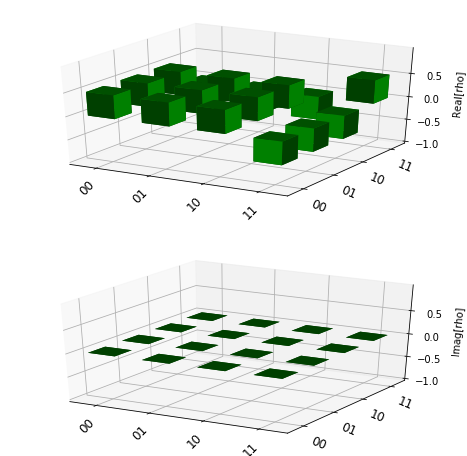

In [3]:
U_had = np.array([[1,1],[1,-1]])/np.sqrt(2)
# compute Choi-matrix from unitary
had_choi = outer(vectorize(U_had))
plot_state(had_choi)

### Simulation of process tomography experiment

Next we build the process tomography circuits and execute them on the simulator backend

In [4]:
had_qubits = [0]
had_tomo_circuits = tomo.build_process_tomography_circuits(Q_program, 'had', had_qubits, qr, cr)

>> created process tomography circuits for "had"


In [5]:
backend = 'local_qasm_simulator'
shots = 5000
had_tomo_results = Q_program.execute(had_tomo_circuits, shots=shots, silent=False)

running on backend: local_qasm_simulator


Next we fit the tomographic data

Process Fidelity =  0.999923629639


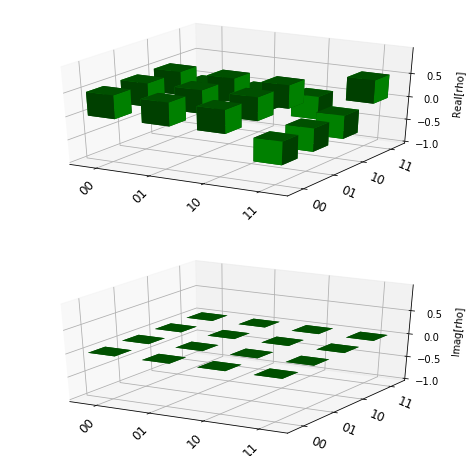

In [6]:
had_process_data = tomo.process_tomography_data(had_tomo_results, 'had', had_qubits)
had_choi_fit = tomo.fit_tomography_data(had_process_data, options={'trace':2})
print('Process Fidelity = ', state_fidelity(vectorize(U_had)/2, had_choi_fit))
plot_state(had_choi_fit)

### Running process tomography on a real device

Now we run tomography on the IBM Quantum Experience device.

In [7]:
# Use the IBM Quantum Experience
backend = 'ibmqx2'
# Take 1000 shots for each measurement basis
# Note: reduce this number for larger number of qubits
shots = 500
# set max credits
max_credits = 5
# Run the experiment
hadqx_tomo_results = Q_program.execute(had_tomo_circuits, backend=backend, shots=shots,
                           max_credits=max_credits, silent=False, wait=20, timeout=240)
print(hadqx_tomo_results)

running on backend: ibmqx2
status = RUNNING (20 seconds)
status = RUNNING (40 seconds)
COMPLETED


Process Fidelity =  0.972411714819


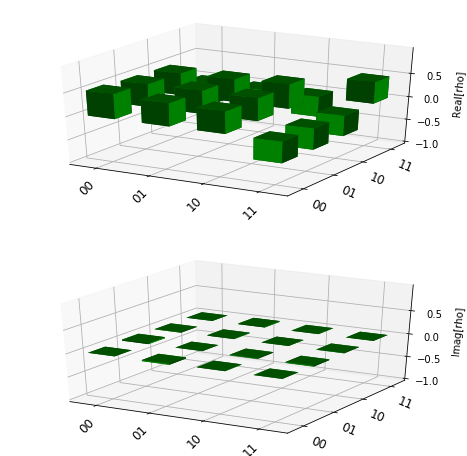

In [8]:
hadqx_process_data = tomo.process_tomography_data(hadqx_tomo_results, 'had', had_qubits)
hadqx_choi_fit = tomo.fit_tomography_data(hadqx_process_data, options={'trace':2})
print('Process Fidelity = ', state_fidelity(vectorize(U_had)/2, hadqx_choi_fit))
plot_state(hadqx_choi_fit)

## Process tomography of a CNOT gate

We will demonstrate a process tomography experiment for a CNOT gate.

### Visualization of the ideal process

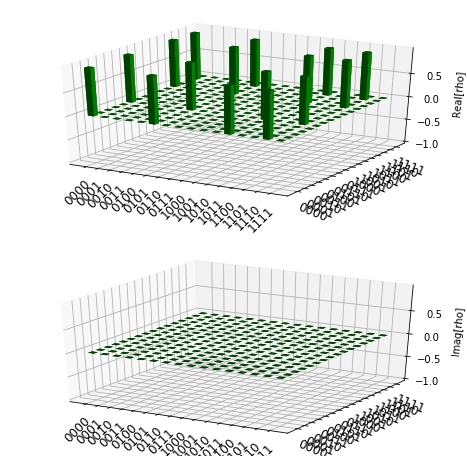

In [9]:
U_cnot = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
# compute Choi-matrix from unitary
cnot_choi = outer(vectorize(U_cnot))
plot_state(cnot_choi)

### Simulation of process tomography experiment

Our test circuit simply consists of a quantum program of two qubits with a single gate, the CNOT gate. Note that we must include a two-qubit register to record measurement outcomes.


In [10]:
cnot_qubits = [0,1]
cnot_tomo_circuits = tomo.build_process_tomography_circuits(Q_program, 'cnot', cnot_qubits, qr, cr)

>> created process tomography circuits for "cnot"


In [11]:
backend = 'local_qasm_simulator'
shots = 5000
print('>> compiling cirucits...')
start = time.clock() # time compilation time
cnot_tomo_results = Q_program.execute(cnot_tomo_circuits, backend=backend, shots=shots, silent=False)
t = round(time.clock()-start, 1)
print('>> time taken:', t)
cnot_process_data = tomo.process_tomography_data(cnot_tomo_results, 'cnot', cnot_qubits)

>> compiling cirucits...
running on backend: local_qasm_simulator
>> time taken: 271.3


Now we fit the data and plot the results

Process Fidelity =  0.999648301373


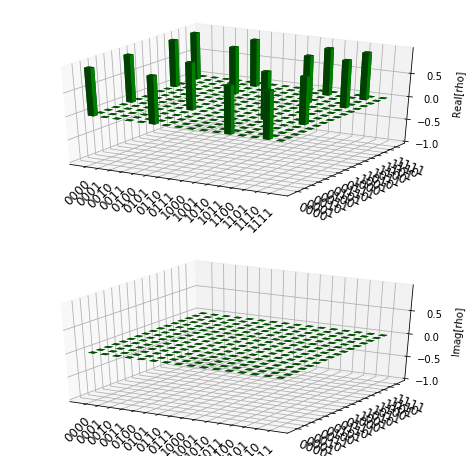

In [12]:
cnot_choi_fit = tomo.fit_tomography_data(cnot_process_data, options={'trace':4})
print('Process Fidelity = ', state_fidelity(vectorize(U_cnot)/4, cnot_choi_fit))
plot_state(cnot_choi_fit)